In [89]:
import os

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings

warnings.filterwarnings('ignore')

In [91]:
df = pd.read_csv("csv/train.csv")

In [92]:
print(df.head())
print(df.info())

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None


In [93]:
df = df.drop(['store', 'item'], axis=1)

In [94]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB
None


CONVERTER DATA DE OBJETO PRA DATETIME DATATYPE ANIMAL

In [95]:
df['date'] = pd.to_datetime(df['date'])

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


converter dias para mês(bekbrace)

In [97]:
df['date'] = df['date'].dt.to_period('M')
Vendas_mensais = df.groupby('date').sum().reset_index()

convertendo pra linha do tempo

In [98]:
df['date'] = Vendas_mensais['date'].dt.to_timestamp()

In [99]:
Vendas_mensais.head(10)

,date,sales
0,2013-01,454904
1,2013-02,459417
2,2013-03,617382
3,2013-04,682274
4,2013-05,763242
5,2013-06,795597
6,2013-07,855922
7,2013-08,766761
8,2013-09,689907
9,2013-10,656587


Visualização

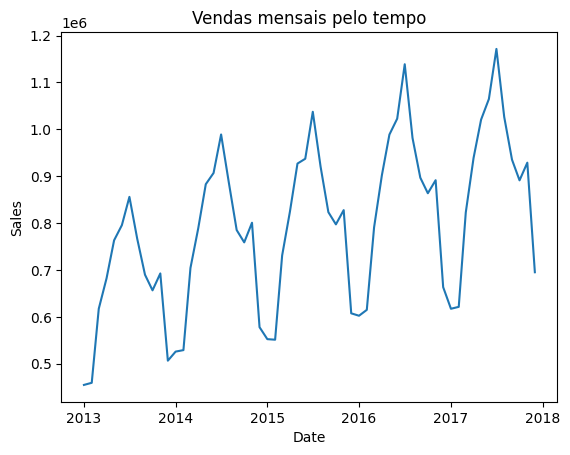

In [100]:
plt.Figure(figsize=(12,6))
plt.plot(Vendas_mensais['date'].dt.to_timestamp(), Vendas_mensais['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Vendas mensais pelo tempo')
plt.show()

chamando diferença pra dados estácionarios

In [101]:
Vendas_mensais['vendas_diff'] = Vendas_mensais['sales'].diff()
Vendas_mensais = Vendas_mensais.dropna()
Vendas_mensais.head(10)

,date,sales,vendas_diff
1,2013-02,459417,4513.0
2,2013-03,617382,157965.0
3,2013-04,682274,64892.0
4,2013-05,763242,80968.0
5,2013-06,795597,32355.0
6,2013-07,855922,60325.0
7,2013-08,766761,-89161.0
8,2013-09,689907,-76854.0
9,2013-10,656587,-33320.0
10,2013-11,692643,36056.0


^^^ fazendo a diferença do mes anterior
617382 - 459417 = 157965

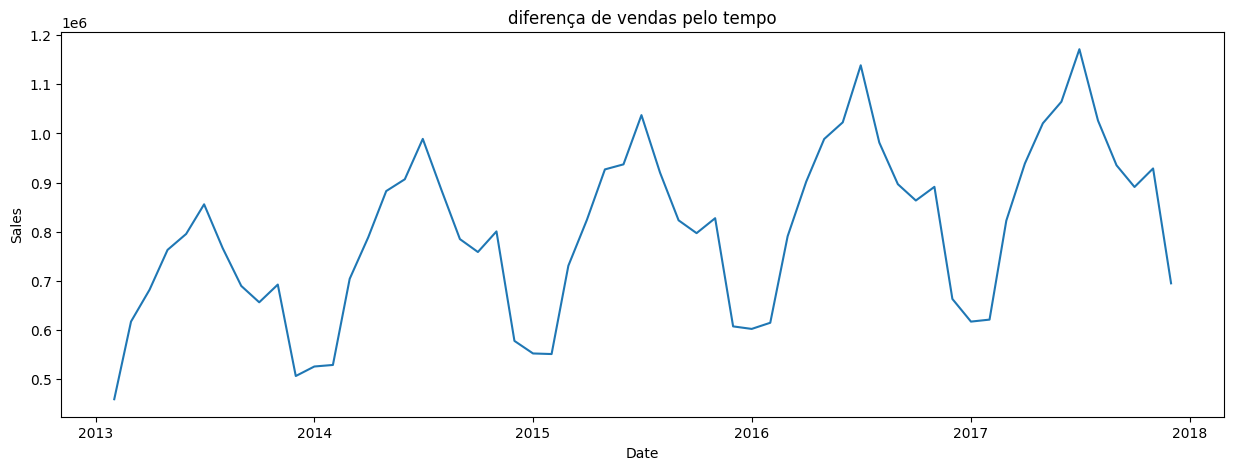

In [102]:
plt.figure(figsize=(15,5))
plt.plot(Vendas_mensais['date'].dt.to_timestamp(), Vendas_mensais['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('diferença de vendas pelo tempo')
plt.show()

preparando data pra treinamento

In [103]:
supervised_data = Vendas_mensais.drop(['date', 'sales'], axis=1)

In [104]:
for i in range(1, 13):
    col_name = 'mes' + str(i)
    supervised_data[col_name] = supervised_data['vendas_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,vendas_diff,mes1,mes2,mes3,mes4,mes5,mes6,mes7,mes8,mes9,mes10,mes11,mes12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


dados de treinamento e validação

In [105]:
Treino_data = supervised_data[:-12]
Val_data = supervised_data[-12:]
print("Treino shape: ", Treino_data.shape)
print("Validação shape: ", Val_data.shape)

Treino shape:  (35, 13)
Validação shape:  (12, 13)


In [106]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(Treino_data)
Treino_data = scaler.transform(Treino_data)
Val_data = scaler.transform(Val_data)

In [107]:
X_Treino, Y_Treino = Treino_data[:,1:], Treino_data[:,0:1]
X_Val, Y_Val = Val_data[:,1:], Val_data[:,0:1]
Y_Treino = Y_Treino.ravel()
Y_Val = Y_Val.ravel()
print("X_Treino shape: ", X_Treino.shape)
print("Y_Treino shape: ", Y_Treino.shape)
print("X_Val shape: ", X_Val.shape)
print("Y_Val shape: ", Y_Val.shape)

X_Treino shape:  (35, 12)
Y_Treino shape:  (35,)
X_Val shape:  (12, 12)
Y_Val shape:  (12,)


dataframe de predição pra dar merge nas predições de vendas dos algoritmos anterioires

In [108]:
dates_for_pred = Vendas_mensais['date'][-12:].reset_index(drop=True)
df_pred = pd.DataFrame(dates_for_pred)

valor pra comparação

In [109]:
print(df.columns)

Index(['date', 'sales'], dtype='object')


In [110]:
Vendas_reais = Vendas_mensais['sales'][-13:].to_list()
print(Vendas_reais)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


criando o modelo de regressão linear e de predição

In [111]:
RL_model = LinearRegression()
RL_model.fit(X_Treino, Y_Treino)
RL_pre = RL_model.predict(X_Treino)

In [112]:
RL_pre = RL_pre.reshape(-1, 1)
# essa matriz contem o input original + a previsão
RL_pre_val_set = np.concatenate([RL_pre, X_Treino], axis=1)
RL_pre_val_set = scaler.inverse_transform(RL_pre_val_set)

Processo de previsão e reconstrução dos valores reais de vendas(Como o modelo estava apresentando previsões erroneas e imprecisas usei a IA para me ajudar a bolar uma solução e debuggar o bloco, minha mente tava só o pó.)

In [113]:
# Make predictions on validation data
RL_pre_val = RL_model.predict(X_Val)
RL_pre_val = RL_pre_val.reshape(-1, 1)

# Inverse transform the validation predictions
RL_pre_val_set = np.concatenate([RL_pre_val, X_Val], axis=1)
RL_pre_val_set = scaler.inverse_transform(RL_pre_val_set)

# Convert differenced predictions back to actual sales values
result_list = []
for i in range(len(RL_pre_val_set)):
    result_list.append(RL_pre_val_set[i][0] + Vendas_reais[i])

RL_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = df_pred.copy()
predict_df['Linear Prediction'] = RL_pre_series.values

In [114]:
print(predict_df)

       date  Linear Prediction
0   2017-01       6.479148e+05
1   2017-02       6.283374e+05
2   2017-03       8.195190e+05
3   2017-04       9.436391e+05
4   2017-05       1.033653e+06
5   2017-06       1.065286e+06
6   2017-07       1.201561e+06
7   2017-08       1.002123e+06
8   2017-09       9.415142e+05
9   2017-10       9.080646e+05
10  2017-11       9.167461e+05
11  2017-12       6.947978e+05


In [115]:
Rl_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], Vendas_mensais['sales'][-12:]))
RL_mae = mean_absolute_error(predict_df['Linear Prediction'], Vendas_mensais['sales'][-12:])
Rl_R2 = r2_score(predict_df['Linear Prediction'], Vendas_mensais['sales'][-12:])
print("Regressão Linear MSE: ", Rl_mse)
print("Regressão Linear MAE: ", RL_mae)
print("Regressão Linear R2: ", Rl_R2)

Regressão Linear MSE:  16221.272385416896
Regressão Linear MAE:  12433.184266490784
Regressão Linear R2:  0.9906152516380968


Visualização da predição

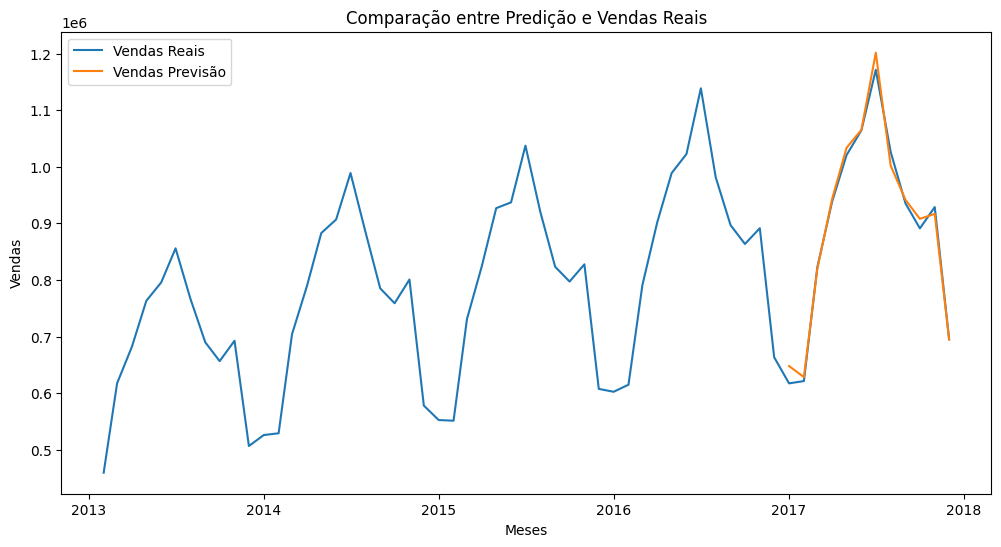

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(Vendas_mensais['date'].dt.to_timestamp(), Vendas_mensais['sales'], label='Vendas Reais')
plt.plot(predict_df['date'].dt.to_timestamp(), predict_df['Linear Prediction'], label='Vendas Previsão')
plt.title('Comparação entre Predição e Vendas Reais')
plt.xlabel('Meses')
plt.ylabel('Vendas')
plt.legend()
plt.show()

Visualização do aprendizado no grafico de dispersão

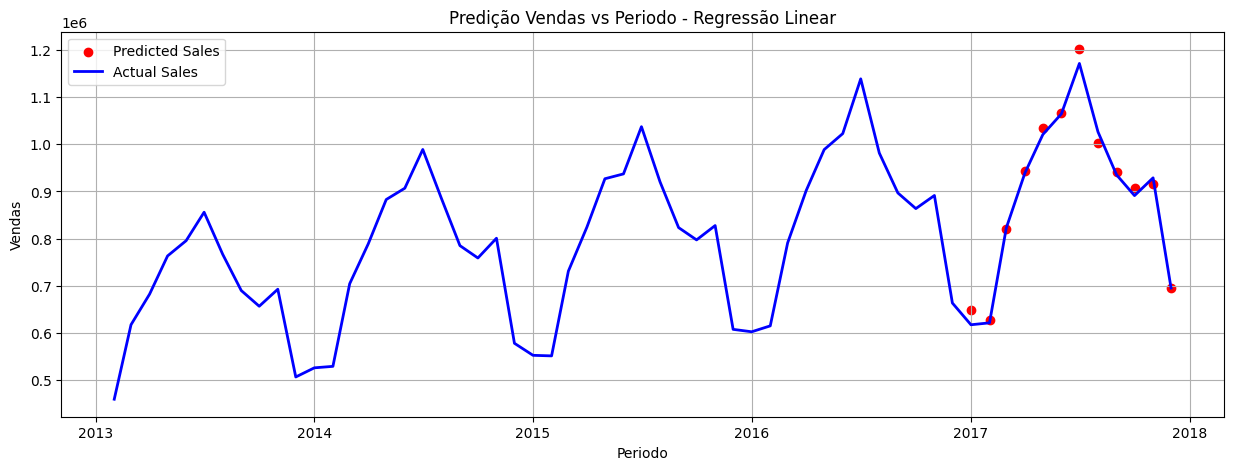

In [117]:
plt.figure(figsize=(15,5))
plt.scatter(predict_df['date'].dt.to_timestamp(), predict_df['Linear Prediction'], color='red', label='Predicted Sales')
plt.plot(Vendas_mensais['date'].dt.to_timestamp(), Vendas_mensais['sales'], color='blue', linewidth=2, label='Actual Sales')
plt.xlabel('Periodo')
plt.ylabel('Vendas')
plt.title('Predição Vendas vs Periodo - Regressão Linear')
plt.legend()
plt.grid(True)
plt.show()